### IMPORT PACKAGES AND INITIALIZE ENVIRONMENT

In [1]:
import joblib
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate

import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC



nltk.download('sentiwordnet')


[nltk_data] Downloading package sentiwordnet to C:\Users\Boyu
[nltk_data]     Wu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [2]:
data = pd.read_csv(r'C:\Users\Boyu Wu\Documents\RWTH_Work\MA-Test\archive\all-data.csv', encoding='ISO-8859-1', header = None)
data.columns = ["labels", "text"]

Visualizing the distribution of financial news articles by their sentiment labels (positive, neutral, negative)/ It counts the occurrences of each label, assigns custom colors to each category, and then plots the bar chart to display the count of articles in each sentiment category. 

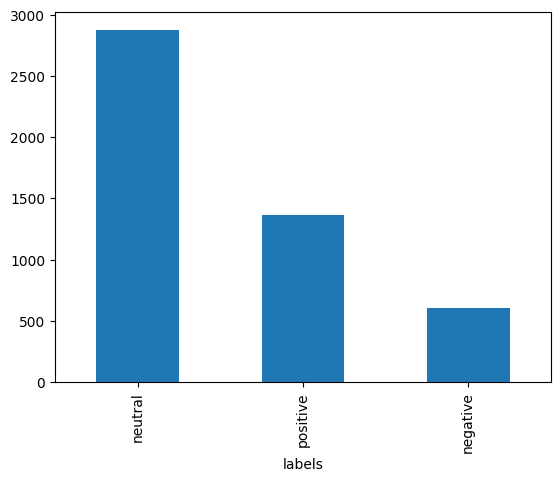

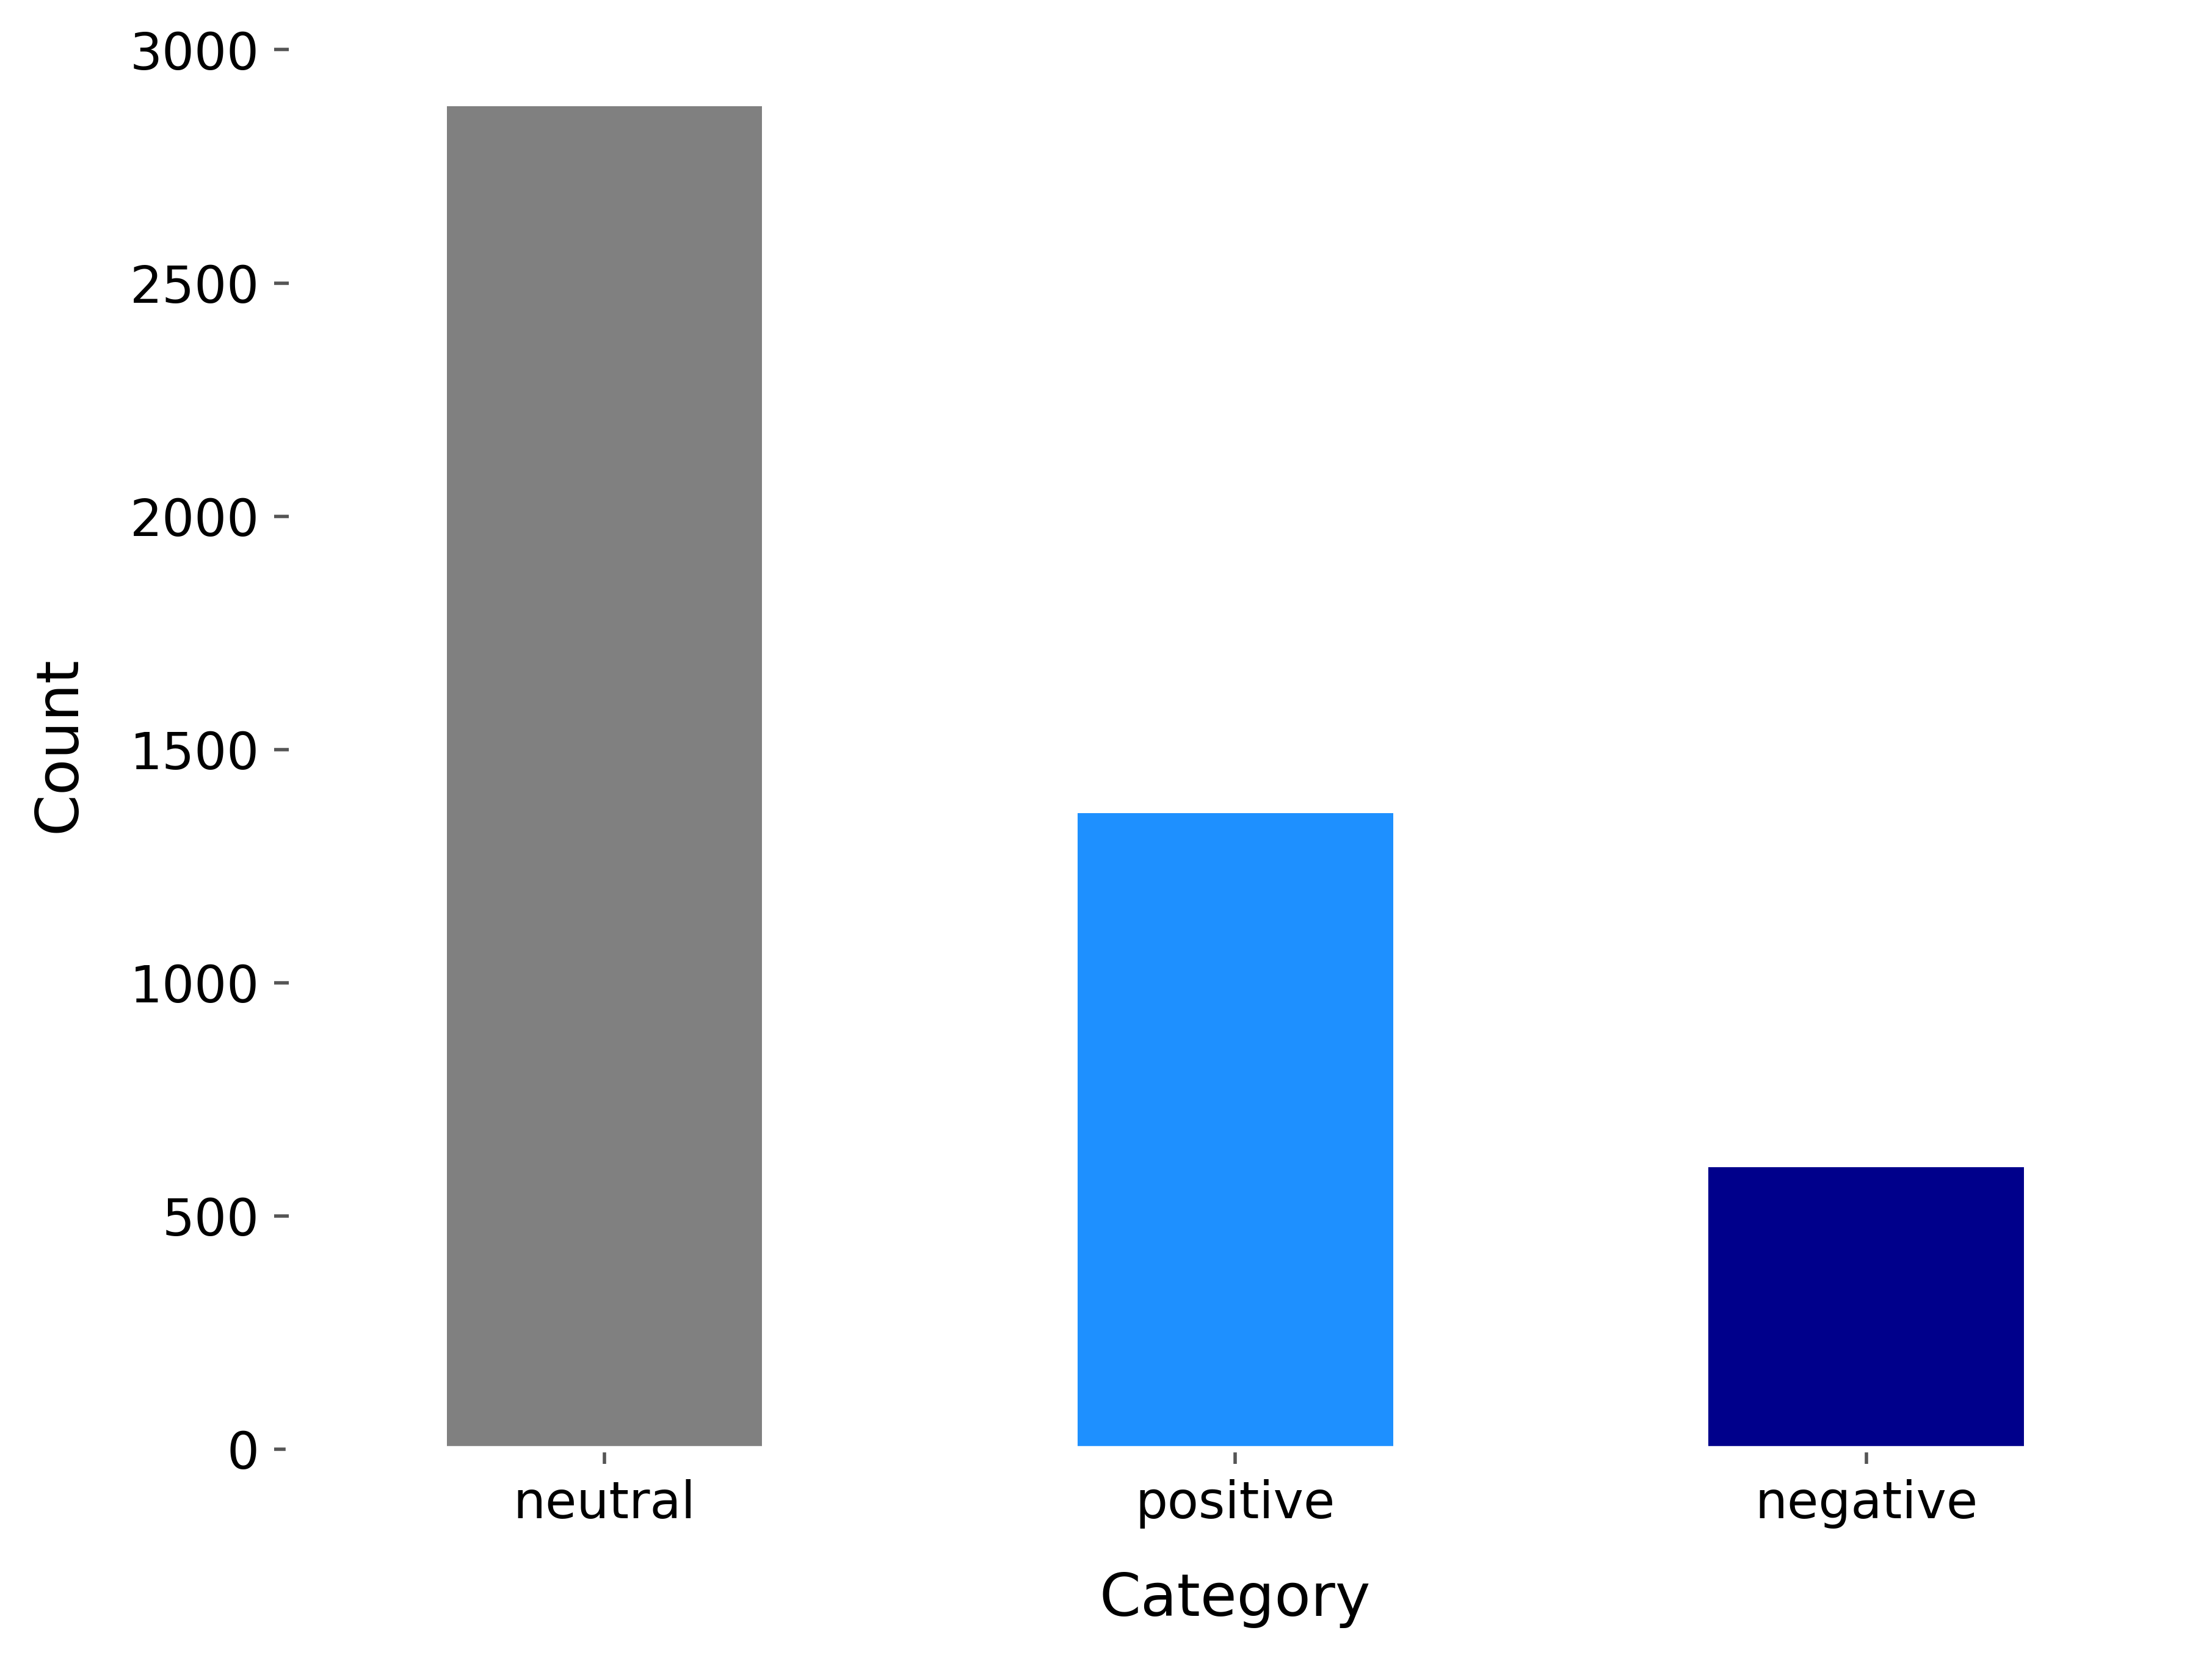

4846

In [3]:
data['labels'].value_counts().plot(kind='bar')
label_counts = data['labels'].value_counts()

colors = {'positive': 'dodgerblue', 'neutral': 'gray', 'negative': 'darkblue'}

# Apply 'ggplot' style for a clean look
plt.style.use('ggplot')

# Create a new figure with a clean background
plt.figure(figsize=(8, 6), dpi=500)

# Plotting the bar plot with custom blue-based colors
label_counts.plot(kind='bar', color=[colors[label] for label in label_counts.index])

# Customizing the plot appearance
plt.xlabel('Category', fontsize=14, labelpad=10, color='black')
plt.ylabel('Count', fontsize=14, labelpad=10, color='black')
plt.xticks(rotation=0, fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

# Remove the grid
plt.grid(False)

# Modify spines (borders around the plot)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Set the background color to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Display the plot
plt.show()

# Display the length of the DataFrame
len(data)

Preprocessing the text data, this code removes punctuation and digits, tokenizes the text, removes stopwords, and lemmatizes the words. It then joins the tokens back into a single string and applies this preprocessing function to the ‘text’ column of the dataset, storing the results in a new column.

In [4]:
def preprocess_text(text):
    # Remove punctuation and digits
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # Assuming verbs, change if needed
    
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text



# Apply preprocessing to your data
data['text_lemmatized'] = data['text'].apply(preprocess_text)

In [5]:
data['text_length'] = data['text'].apply(len)
average_text_length = data['text_length'].mean()

# Calculate average length of 'text_lemmatized'
data['text_lemmatized_length'] = data['text_lemmatized'].apply(len)
average_text_lemmatized_length = data['text_lemmatized_length'].mean()

print("Average length of text:", average_text_length)
print("Average length of text_lemmatized:", average_text_lemmatized_length)

Average length of text: 128.1320676846884
Average length of text_lemmatized: 86.49339661576558


#### Add helper functions

These helper functions are simplifying the integration of our code into our final thesis.

In [6]:
def aggregate_classification_report(classification_reports, accuracy_scores):
    aggregate_classification_report = {
        'negative': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
        'neutral': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
        'positive': {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    }

    # Aggregate metrics from each fold
    for report in classification_reports:
        lines = report.split('\n')
        for i in range(2, 5):  # Extracting metrics (precision, recall, f1-score, support)
            line = lines[i].strip().split()
            class_name = line[0]
            precision = float(line[1])
            recall = float(line[2])
            f1_score = float(line[3])
            support = float(line[4])
            # Append to aggregate dictionary
            aggregate_classification_report[class_name]['precision'].append(precision)
            aggregate_classification_report[class_name]['recall'].append(recall)
            aggregate_classification_report[class_name]['f1-score'].append(f1_score)
            aggregate_classification_report[class_name]['support'].append(support)

    # Calculate mean values for each class
    mean_classification_report = {}
    for class_name, metrics in aggregate_classification_report.items():
        mean_precision = np.mean(metrics['precision'])
        mean_recall = np.mean(metrics['recall'])
        mean_f1_score = np.mean(metrics['f1-score'])
        mean_support = np.mean(metrics['support'])
        mean_classification_report[class_name] = {
            'precision': mean_precision,
            'recall': mean_recall,
            'f1-score': mean_f1_score,
            'support': mean_support
        }

    # Calculate overall metrics: accuracy, macro avg, weighted avg
    mean_accuracy = np.mean(accuracy_scores)

    # Macro average: simply average of precision, recall, f1-score across classes
    macro_avg = {
        'precision': np.mean([mean_classification_report[class_name]['precision'] for class_name in mean_classification_report]),
        'recall': np.mean([mean_classification_report[class_name]['recall'] for class_name in mean_classification_report]),
        'f1-score': np.mean([mean_classification_report[class_name]['f1-score'] for class_name in mean_classification_report]),
        'support': np.sum([mean_classification_report[class_name]['support'] for class_name in mean_classification_report])
    }

    # Weighted average: weighted by support (number of instances) of each class
    total_support = sum([mean_classification_report[class_name]['support'] for class_name in mean_classification_report])
    weighted_avg = {
        'precision': sum([mean_classification_report[class_name]['precision'] * mean_classification_report[class_name]['support'] / total_support for class_name in mean_classification_report]),
        'recall': sum([mean_classification_report[class_name]['recall'] * mean_classification_report[class_name]['support'] / total_support for class_name in mean_classification_report]),
        'f1-score': sum([mean_classification_report[class_name]['f1-score'] * mean_classification_report[class_name]['support'] / total_support for class_name in mean_classification_report]),
        'support': total_support
    }

    # Build the final mean_classification_report dictionary
    mean_classification_report = {
        **mean_classification_report,
        'accuracy': mean_accuracy,
        'macro avg': macro_avg,
        'weighted avg': weighted_avg
    }
    print(mean_classification_report)
    return mean_classification_report


In [7]:
def classification_report_to_latex(mean_classification_report):
    latex_classification_report = """
    \\begin{tabular}{lcccc}
    \\toprule
    & Precision & Recall & F1-score & Support \\\\
    \\midrule
    """

    for label in ['negative', 'neutral', 'positive']:
        latex_classification_report += f"{label.capitalize()} & " \
                                    f"{mean_classification_report[label]['precision']:0.2f} & " \
                                    f"{mean_classification_report[label]['recall']:0.2f} & " \
                                    f"{mean_classification_report[label]['f1-score']:0.2f} & " \
                                    f"{mean_classification_report[label]['support']:0.0f} \\\\\n"

    latex_classification_report += f"\\midrule\nAccuracy & & & {mean_classification_report['accuracy']:0.2f} & {mean_classification_report['weighted avg']['support']:0.0f} \\\\\n"
    latex_classification_report += f"Macro avg & {mean_classification_report['macro avg']['precision']:0.2f} & " \
                                f"{mean_classification_report['macro avg']['recall']:0.2f} & " \
                                f"{mean_classification_report['macro avg']['f1-score']:0.2f} & " \
                                f"{mean_classification_report['macro avg']['support']:0.0f} \\\\\n"
    latex_classification_report += f"Weighted avg & {mean_classification_report['weighted avg']['precision']:0.2f} & " \
                                f"{mean_classification_report['weighted avg']['recall']:0.2f} & " \
                                f"{mean_classification_report['weighted avg']['f1-score']:0.2f} & " \
                                f"{mean_classification_report['weighted avg']['support']:0.0f} \\\\\n"
    latex_classification_report += "\\bottomrule\n\\end{tabular}"

    # Print mean classification report in LaTeX format
    print("Mean Classification Report in LaTeX format:")
    print(latex_classification_report)

    display(pd.DataFrame(mean_classification_report).transpose())

### BENCHMARKING ALGORITHMS

#### WordNetLemmatizer

Analyzing the sentiment of text data, this code uses the SentiWordNet lexicon to calculate sentiment scores for each text.




This is done for all other algorithms as well: 

It then converts these scores into sentiment labels (negative, neutral, positive) and evaluates the performance of this sentiment analysis using stratified k-fold cross-validation. The results, including accuracy scores, classification reports, and confusion matrices, are averaged and visualized to provide insights into the model’s performance. Treshhold manually tuned for good enough performance (for our efforts). 

{'negative': {'precision': 0.27799999999999997, 'recall': 0.05, 'f1-score': 0.082, 'support': 120.8}, 'neutral': {'precision': 0.6079999999999999, 'recall': 0.844, 'f1-score': 0.708, 'support': 575.8}, 'positive': {'precision': 0.42000000000000004, 'recall': 0.22999999999999998, 'f1-score': 0.298, 'support': 272.6}, 'accuracy': 0.5714006362175906, 'macro avg': {'precision': 0.43533333333333335, 'recall': 0.3746666666666667, 'f1-score': 0.36266666666666664, 'support': 969.1999999999999}, 'weighted avg': {'precision': 0.513991745769707, 'recall': 0.5723413124226167, 'f1-score': 0.5146582748658688, 'support': 969.1999999999999}}
Mean Confusion Matrix:
[[  6 106   9]
 [ 12 485  79]
 [  3 207  63]]
Mean Classification Report:
{'negative': {'precision': 0.27799999999999997, 'recall': 0.05, 'f1-score': 0.082, 'support': 120.8}, 'neutral': {'precision': 0.6079999999999999, 'recall': 0.844, 'f1-score': 0.708, 'support': 575.8}, 'positive': {'precision': 0.42000000000000004, 'recall': 0.22999999

,precision,recall,f1-score,support
negative,0.278000,0.050000,0.082000,120.800000
neutral,0.608000,0.844000,0.708000,575.800000
positive,0.420000,0.230000,0.298000,272.600000
accuracy,0.571401,0.571401,0.571401,0.571401
macro avg,0.435333,0.374667,0.362667,969.200000
weighted avg,0.513992,0.572341,0.514658,969.200000


[0.5639175257731959, 0.56656346749226, 0.5810113519091847, 0.5748194014447885, 0.5706914344685242]


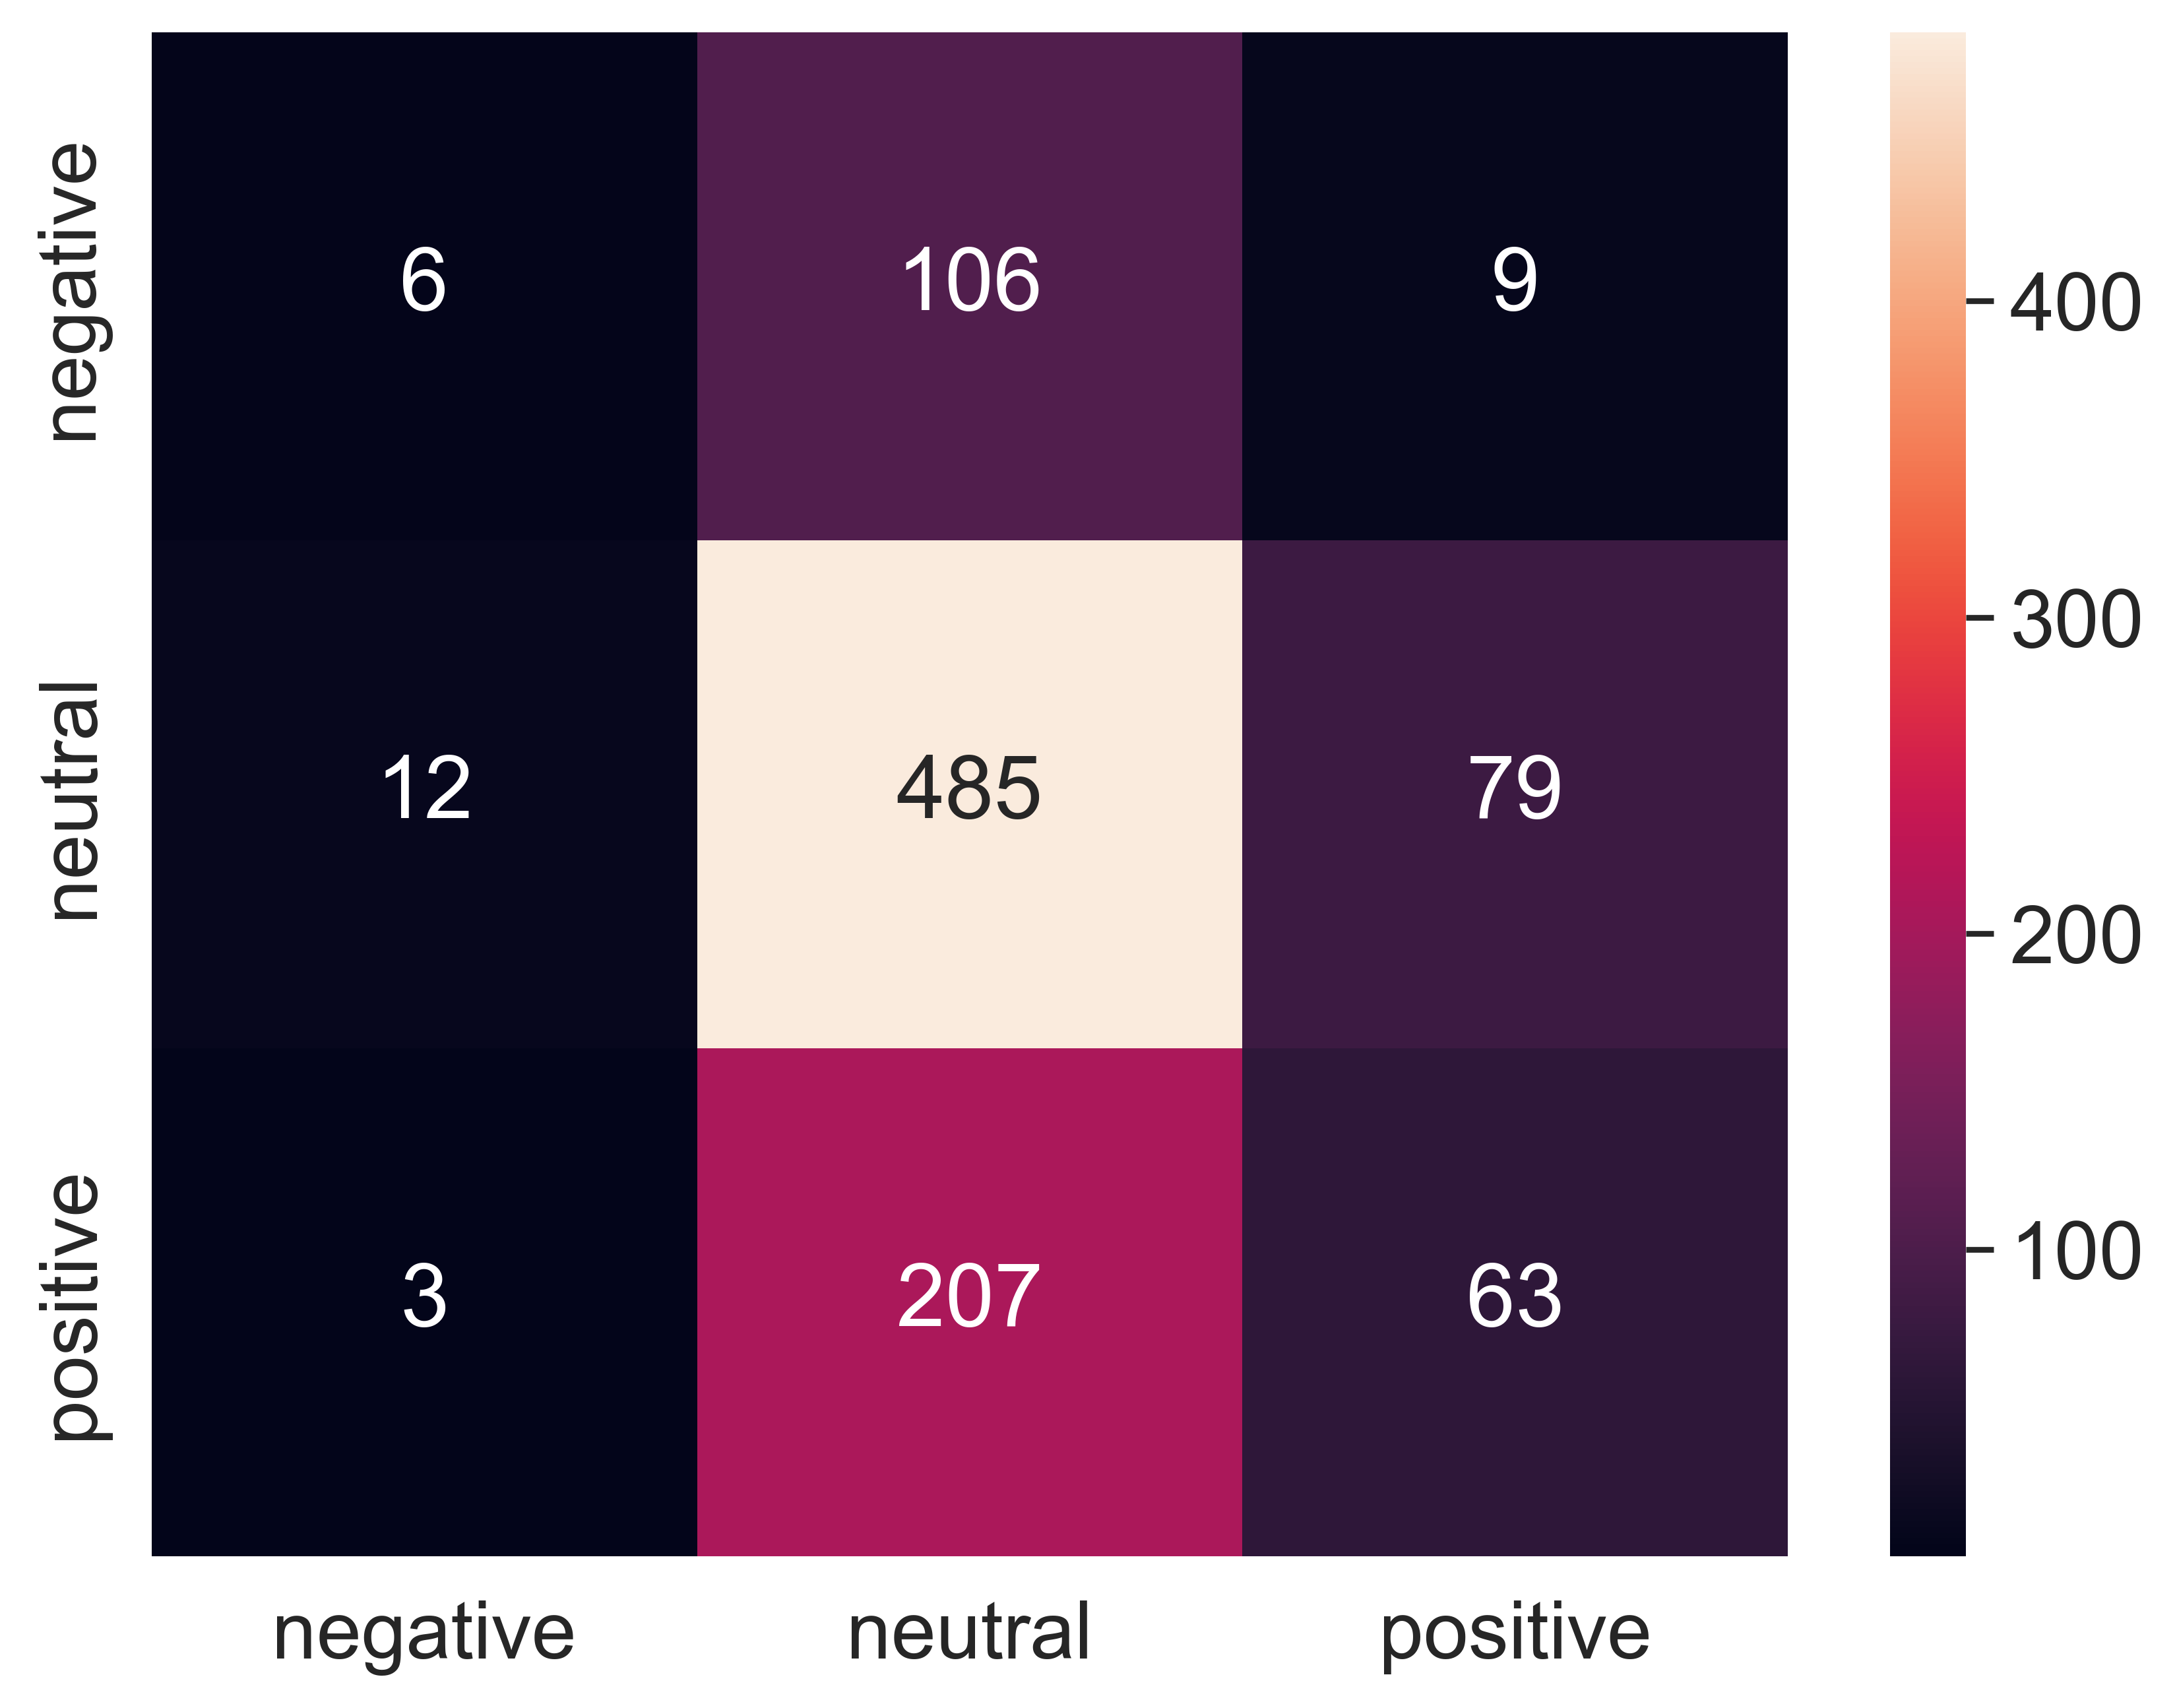

In [8]:
def get_sentiwordnet_score(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token not in string.punctuation]
    
    pos_score = 0
    neg_score = 0
    
    for token in tokens:
        synsets = wn.synsets(token)
        if synsets:
            senti_synset = swn.senti_synset(synsets[0].name())
            pos_score += senti_synset.pos_score()
            neg_score += senti_synset.neg_score()
    
    return pos_score - neg_score

# Convert sentiment scores to labels
def score_to_label(score):
    if score < -0.51:
        return 'negative'
    elif score > 0.51:
        return 'positive'
    else:
        return 'neutral'

sia = SentimentIntensityAnalyzer()


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 
accuracy_scores_swn = []
classification_reports_swn = []
confusion_matrices_swn = []

for train_index, test_index in skf.split(data[['text', 'text_lemmatized']], data['labels']):
    x_train, x_test = data.iloc[train_index][['text', 'text_lemmatized']], data.iloc[test_index][['text', 'text_lemmatized']]
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    sentiwordnet_scores = [get_sentiwordnet_score(text) for text in x_test['text_lemmatized']]
    y_pred_swn = [score_to_label(score) for score in sentiwordnet_scores]

    accuracy_swn = accuracy_score(y_test, y_pred_swn)
    report_swn = classification_report(y_test, y_pred_swn, target_names=['negative', 'neutral', 'positive'])
    conf_matrix_swn = confusion_matrix(y_test, y_pred_swn, labels=['negative', 'neutral', 'positive'])

    accuracy_scores_swn.append(accuracy_swn)
    classification_reports_swn.append(report_swn)
    confusion_matrices_swn.append(conf_matrix_swn)


mean_conf_matrix = np.round(np.mean(confusion_matrices_swn, axis=0)).astype(int)
mean_classification_report = aggregate_classification_report(classification_reports_swn,accuracy_scores_swn)
print("Mean Confusion Matrix:")
print(mean_conf_matrix)

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  

sns.heatmap(mean_conf_matrix, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

print("Mean Classification Report:")
print(mean_classification_report)

classification_report_to_latex(mean_classification_report)

print(accuracy_scores_swn)


In [9]:
np.sum([0.5123711340206185, 0.5056759545923633, 0.5345717234262126, 0.5386996904024768, 0.5294117647058824])/5

0.5241460534295107

#### VADER (Valence Aware Dictionary for Sentiment Reasoning)

Evaluating the sentiment of text data, this code initializes the SentimentIntensityAnalyzer.

{'negative': {'precision': 0.592, 'recall': 0.06999999999999999, 'f1-score': 0.12200000000000003, 'support': 120.8}, 'neutral': {'precision': 0.634, 'recall': 0.874, 'f1-score': 0.736, 'support': 575.8}, 'positive': {'precision': 0.526, 'recall': 0.308, 'f1-score': 0.39, 'support': 272.6}, 'accuracy': 0.6145253369931802, 'macro avg': {'precision': 0.584, 'recall': 0.41733333333333333, 'f1-score': 0.416, 'support': 969.1999999999999}, 'weighted avg': {'precision': 0.5983887742468015, 'recall': 0.6145955427156418, 'f1-score': 0.5621547668179943, 'support': 969.1999999999999}}
Mean Confusion Matrix:
[[  8 106   7]
 [  3 504  69]
 [  2 186  84]]
Mean Classification Report in LaTeX format:

    \begin{tabular}{lcccc}
    \toprule
    & Precision & Recall & F1-score & Support \\
    \midrule
    Negative & 0.59 & 0.07 & 0.12 & 121 \\
Neutral & 0.63 & 0.87 & 0.74 & 576 \\
Positive & 0.53 & 0.31 & 0.39 & 273 \\
\midrule
Accuracy & & & 0.61 & 969 \\
Macro avg & 0.58 & 0.42 & 0.42 & 969 \\
Weigh

,precision,recall,f1-score,support
negative,0.592000,0.070000,0.122000,120.800000
neutral,0.634000,0.874000,0.736000,575.800000
positive,0.526000,0.308000,0.390000,272.600000
accuracy,0.614525,0.614525,0.614525,0.614525
macro avg,0.584000,0.417333,0.416000,969.200000
weighted avg,0.598389,0.614596,0.562155,969.200000


[0.6247422680412371, 0.6099071207430341, 0.6150670794633643, 0.6160990712074303, 0.6068111455108359]


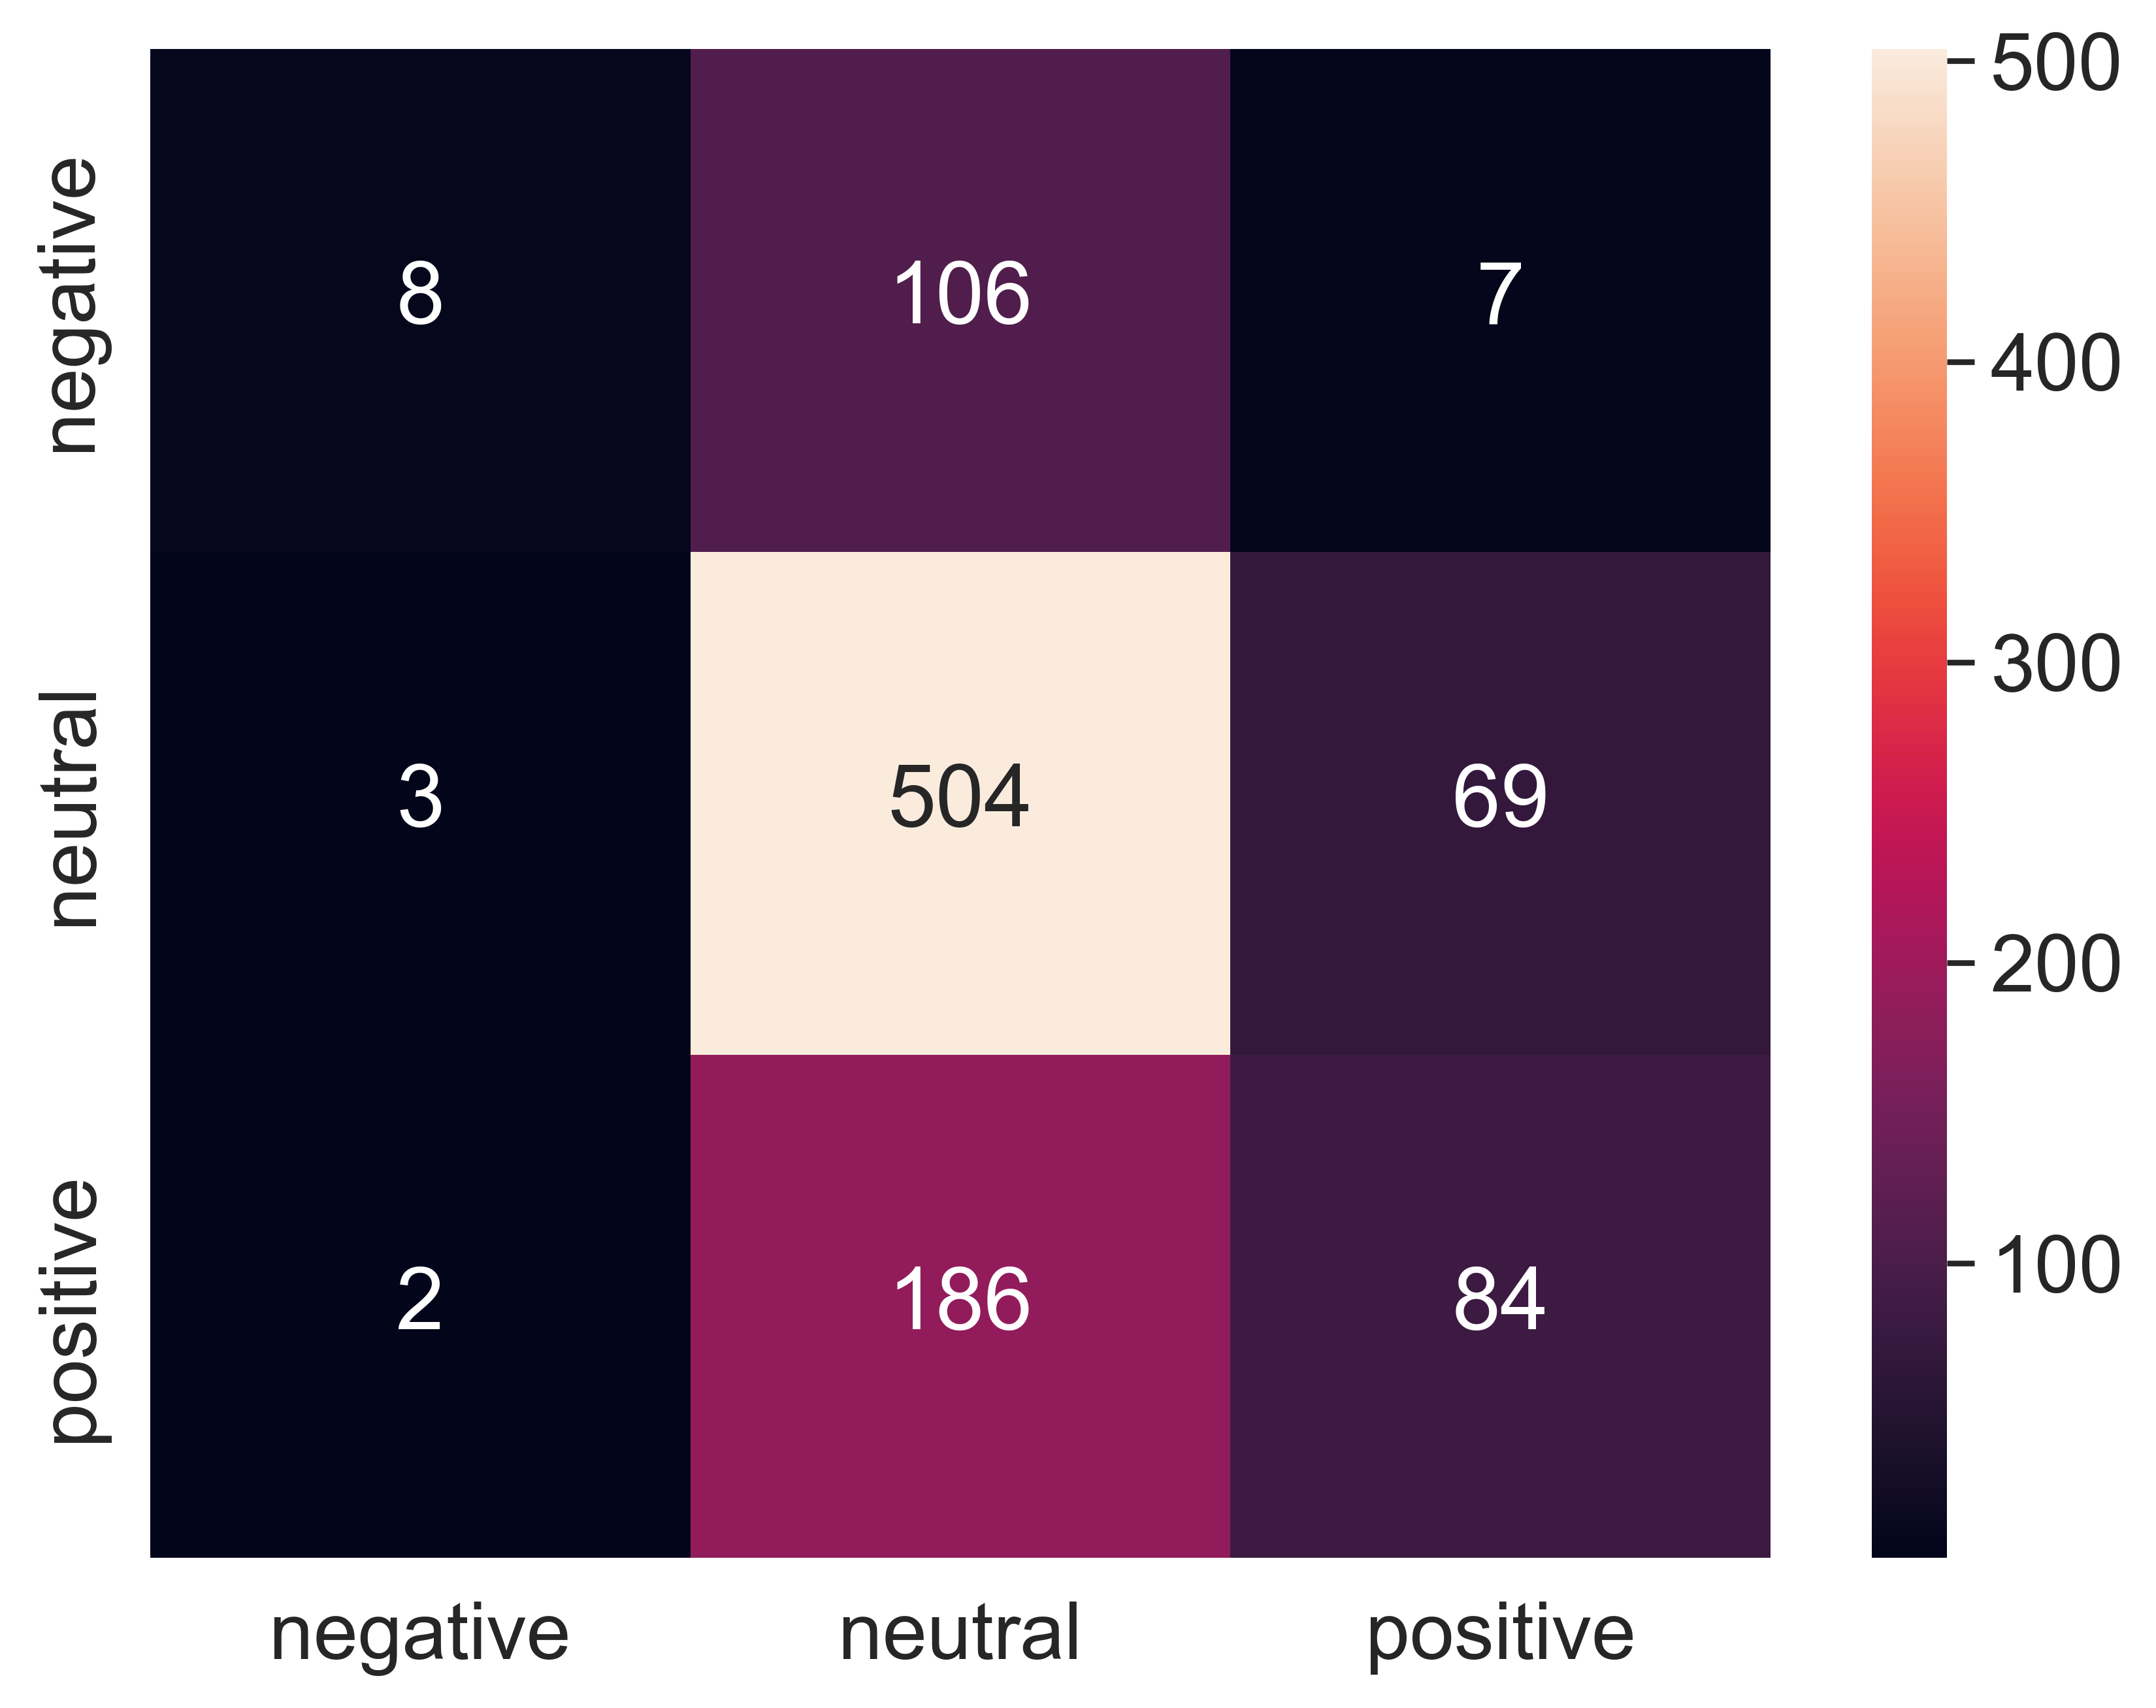

In [10]:


# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Assuming 'data' is your original DataFrame containing 'text', 'text_lemmatized', and 'labels'

# Initialize Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # Adjust n_splits as needed

# Lists to store evaluation metrics across folds
accuracy_scores = []
classification_reports = []
confusion_matrices = []

# Perform stratified K-Fold CV
for train_index, test_index in skf.split(data[['text', 'text_lemmatized']], data['labels']):
    x_train, x_test = data.iloc[train_index][['text', 'text_lemmatized']], data.iloc[test_index][['text', 'text_lemmatized']]
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Compute sentiment scores for each text in x_test
    sia_scores = [sia.polarity_scores(text)['compound'] for text in x_test['text_lemmatized']]

    # Convert sentiment scores to labels
    y_pred_sia = ['positive' if score > 0.51 else 'negative' if score < -0.51 else 'neutral' for score in sia_scores]

    # Compute evaluation metrics for this fold
    accuracy_sia = accuracy_score(y_test, y_pred_sia)
    report_sia = classification_report(y_test, y_pred_sia, target_names=['negative', 'neutral', 'positive'])
    conf_matrix_sia = confusion_matrix(y_test, y_pred_sia, labels=['negative', 'neutral', 'positive'])

    # Append metrics to lists
    accuracy_scores.append(accuracy_sia)
    classification_reports.append(report_sia)
    confusion_matrices.append(conf_matrix_sia)

# Compute mean confusion matrix and classification report
mean_conf_matrix = np.round(np.mean(confusion_matrices, axis=0)).astype(int)
mean_classification_report = aggregate_classification_report(classification_reports,accuracy_scores)

# Print mean confusion matrix
print("Mean Confusion Matrix:")
print(mean_conf_matrix)

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

classification_report_to_latex(mean_classification_report)

print(accuracy_scores)


#### SVM (Support Vector Machine)


Evaluating the performance of a Linear Support Vector Classifier (LinearSVC) with TF-IDF features.

c:\Users\Boyu Wu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Boyu Wu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Boyu Wu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Boyu Wu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

{'negative': {'precision': 0.782, 'recall': 0.5740000000000001, 'f1-score': 0.658, 'support': 120.8}, 'neutral': {'precision': 0.796, 'recall': 0.892, 'f1-score': 0.8400000000000001, 'support': 575.8}, 'positive': {'precision': 0.722, 'recall': 0.624, 'f1-score': 0.668, 'support': 272.6}, 'accuracy': 0.7758975668400838, 'macro avg': {'precision': 0.7666666666666666, 'recall': 0.6966666666666668, 'f1-score': 0.7220000000000001, 'support': 969.1999999999999}, 'weighted avg': {'precision': 0.773441601320677, 'recall': 0.7769863805200166, 'f1-score': 0.768938505984317, 'support': 969.1999999999999}}
Mean Confusion Matrix:
[[ 69  36  15]
 [ 12 513  51]
 [  7  95 170]]
Mean Classification Report:
{'negative': {'precision': 0.782, 'recall': 0.5740000000000001, 'f1-score': 0.658, 'support': 120.8}, 'neutral': {'precision': 0.796, 'recall': 0.892, 'f1-score': 0.8400000000000001, 'support': 575.8}, 'positive': {'precision': 0.722, 'recall': 0.624, 'f1-score': 0.668, 'support': 272.6}, 'accuracy'

c:\Users\Boyu Wu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,precision,recall,f1-score,support
negative,0.782000,0.574000,0.658000,120.800000
neutral,0.796000,0.892000,0.840000,575.800000
positive,0.722000,0.624000,0.668000,272.600000
accuracy,0.775898,0.775898,0.775898,0.775898
macro avg,0.766667,0.696667,0.722000,969.200000
weighted avg,0.773442,0.776986,0.768939,969.200000


[0.7762886597938145, 0.7729618163054696, 0.803921568627451, 0.7657378740970072, 0.760577915376677]
[array([[ 54,  53,  14],
       [ 15, 510,  51],
       [  4,  80, 189]], dtype=int64), array([[ 75,  28,  18],
       [ 10, 505,  61],
       [  7,  96, 169]], dtype=int64), array([[ 77,  34,  10],
       [  8, 543,  25],
       [  7, 106, 159]], dtype=int64), array([[ 67,  36,  17],
       [ 10, 507,  59],
       [  7,  98, 168]], dtype=int64), array([[ 72,  31,  18],
       [ 17, 498,  60],
       [ 12,  94, 167]], dtype=int64)]


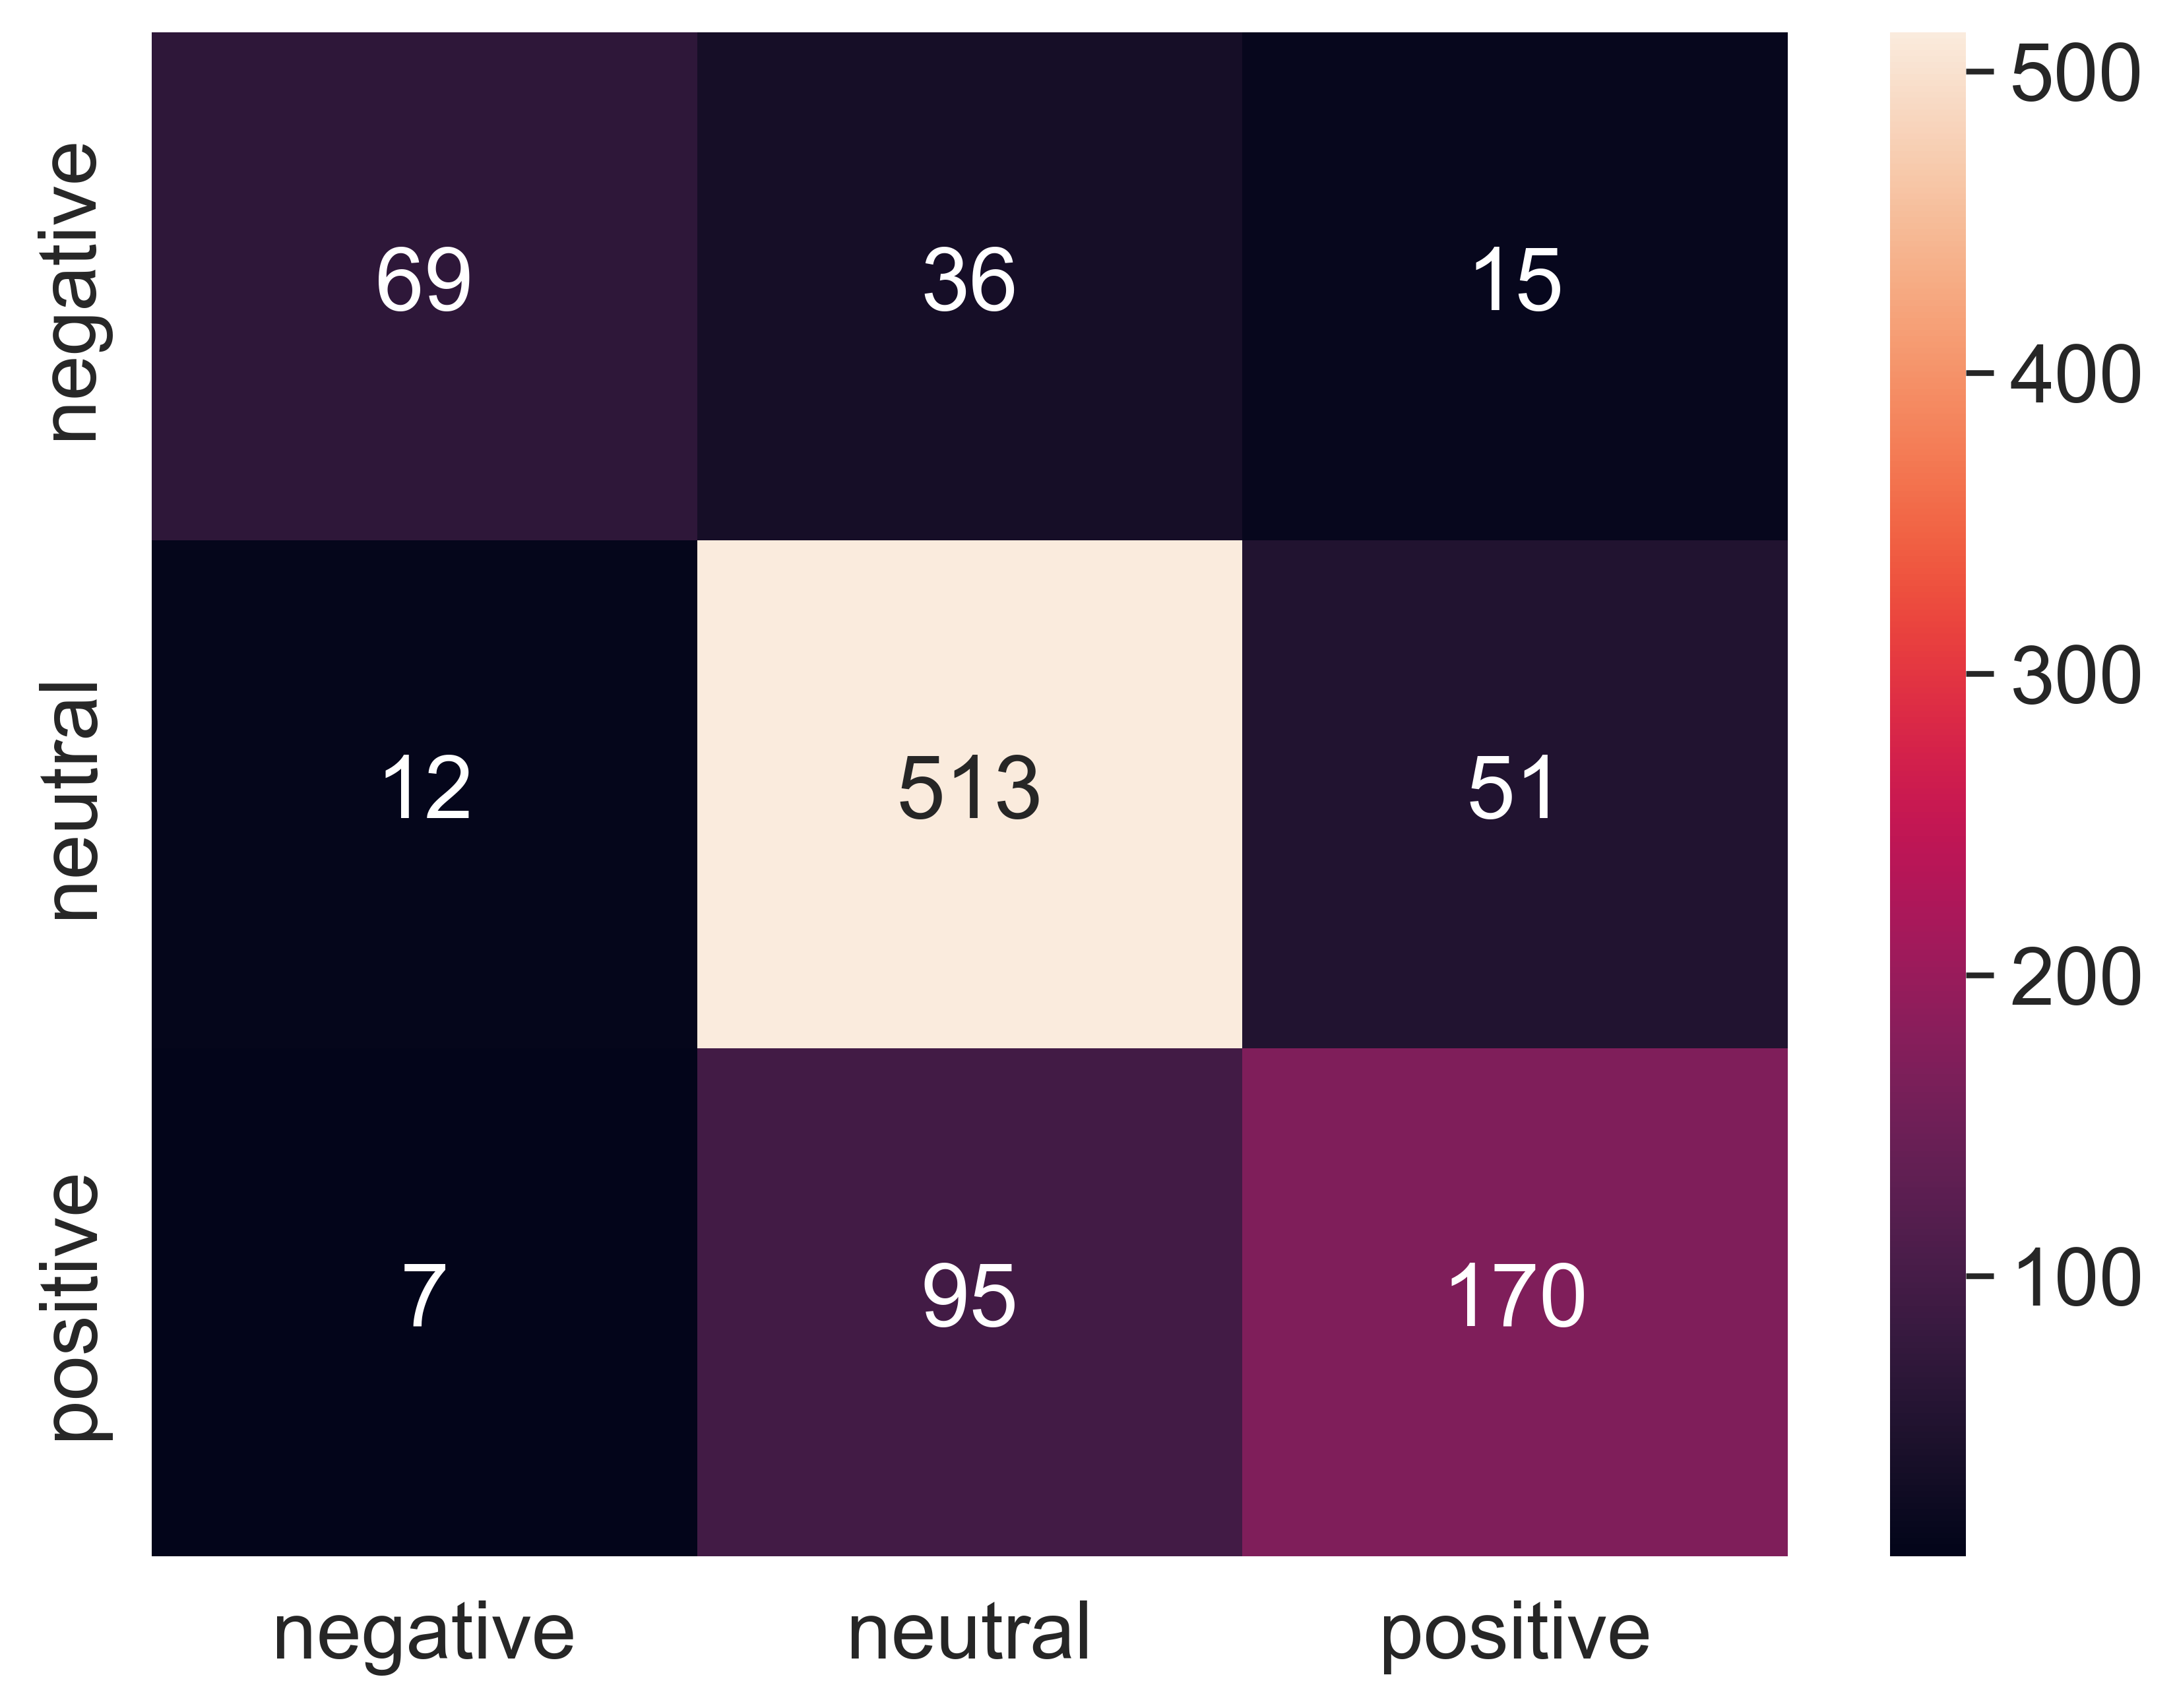

In [11]:
param_grid = {
    'model__C': [0.1, 0.5, 1, 5, 10],  # Example values; adjust as needed
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Example n-grams; adjust as needed
}

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Lists to store evaluation metrics across folds
accuracy_scores_svc = []
classification_reports_svc = []
confusion_matrices_svc = []

# Perform stratified K-Fold CV with GridSearchCV for LinearSVC with TF-IDF
for train_index, test_index in skf.split(data['text'], data['labels']):
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', LinearSVC())
    ])

    # Define GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='accuracy')

    # Train the model with GridSearchCV
    grid_search.fit(x_train, y_train)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Predict the test data
    y_pred_svc = best_model.predict(x_test)

    # Compute evaluation metrics for LinearSVC
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    report_svc = classification_report(y_test, y_pred_svc, target_names=['negative', 'neutral', 'positive'])
    conf_matrix_svc = confusion_matrix(y_test, y_pred_svc, labels=['negative', 'neutral', 'positive'])

    # Append LinearSVC metrics to lists
    accuracy_scores_svc.append(accuracy_svc)
    classification_reports_svc.append(report_svc)
    confusion_matrices_svc.append(conf_matrix_svc)

# Compute mean confusion matrix and classification report for LinearSVC
mean_conf_matrix_svc = np.round(np.mean(confusion_matrices_svc, axis=0)).astype(int)
mean_classification_report_svc = aggregate_classification_report(classification_reports_svc, accuracy_scores_svc)

print("Mean Confusion Matrix:")
print(mean_conf_matrix_svc)

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed
sns.heatmap(mean_conf_matrix_svc, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report:")
print(mean_classification_report_svc)

classification_report_to_latex(mean_classification_report_svc)

print(accuracy_scores_svc)
print(confusion_matrices_svc)

#### Logistic Regression

Evaluating the performance of a Logistic Regression model with TF-IDF features.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # Adjust n_splits as needed

# Lists to store evaluation metrics across folds
accuracy_scores_lr = []
classification_reports_lr = []
confusion_matrices_lr = []


for train_index, test_index in skf.split(data['text'], data['labels']):
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', LogisticRegression())  # You can adjust max_iter as needed
    ])

    # Train the model
    model = pipeline.fit(x_train, y_train)

    # Predict the test data
    y_pred_lr = model.predict(x_test)

    # Compute evaluation metrics for LogisticRegression
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    report_lr = classification_report(y_test, y_pred_lr, target_names=['negative', 'neutral', 'positive'])
    conf_matrix_lr = confusion_matrix(y_test, y_pred_lr, labels=['negative', 'neutral', 'positive'])

    # Append LogisticRegression metrics to lists
    accuracy_scores_lr.append(accuracy_lr)
    classification_reports_lr.append(report_lr)
    confusion_matrices_lr.append(conf_matrix_lr)


# Compute mean confusion matrix and classification report for LinearSVC
mean_conf_matrix_lr = np.round(np.mean(confusion_matrices_lr, axis=0)).astype(int)
mean_classification_report_lr = aggregate_classification_report(classification_reports_lr,accuracy_scores_lr)

print("Mean Confusion Matrix:")
print(mean_conf_matrix_lr)

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix_lr, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report:")
print(mean_classification_report_lr)

classification_report_to_latex(mean_classification_report_lr)

print(accuracy_scores_lr)
print(mean_conf_matrix_lr)

#### MLP (Multi-Layer Perceptron)


Evaluating the performance of a Multi-Layer Perceptron classifier with TF-IDF features.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # Adjust n_splits as needed


accuracy_scores_mlp = []
classification_reports_mlp = []
confusion_matrices_mlp = []

for train_index, test_index in skf.split(data['text'], data['labels']):
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('model', MLPClassifier(learning_rate_init=0.005, random_state=0))  # Specify MLPClassifier parameters
    ])

    # Train the model
    model = pipeline.fit(x_train, y_train)

    # Predict the test data
    y_pred_mlp = model.predict(x_test)

    # Compute evaluation metrics for MLPClassifier
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    report_mlp = classification_report(y_test, y_pred_mlp, target_names=['negative', 'neutral', 'positive'])
    conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp, labels=['negative', 'neutral', 'positive'])

    # Append MLPClassifier metrics to lists
    accuracy_scores_mlp.append(accuracy_mlp)
    classification_reports_mlp.append(report_mlp)
    confusion_matrices_mlp.append(conf_matrix_mlp)
    print(accuracy_mlp)

mean_conf_matrix_mlp = np.round(np.mean(confusion_matrices_mlp, axis=0)).astype(int)
mean_classification_report_mlp = aggregate_classification_report(classification_reports_mlp, accuracy_scores_mlp)

print("Mean Confusion Matrix (MLPClassifier):")
print(mean_conf_matrix_mlp)

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix_mlp, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report (MLPClassifier):")
print(mean_classification_report_mlp)

# Convert mean_classification_report_mlp to LaTeX format if needed
classification_report_to_latex(mean_classification_report_mlp)

print(accuracy_scores_mlp)


#### Hyperparameter Tuned MLP

Evaluating the performance of a hyperparameter tuned Multi-Layer Perceptron (MLP) classifier with TF-IDF features. Tuned via Gridsearch and a good amount of hyperparameters to try - Combating overfitting of data - reducing variance for bias.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # Adjust n_splits as needed

accuracy_scores_mlp = []
classification_reports_mlp = []
confusion_matrices_mlp = []


# Define the pipeline with TF-IDF vectorizer and MLP classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MLPClassifier(learning_rate_init=0.005, random_state=0))  
])

# Define hyperparameters to tune
parameters = {
    'model__hidden_layer_sizes': [(20,), (25,) ,(30,), (35,)],  # sizes of hidden layers
    'model__activation': ['relu'],
    'model__alpha': [0.7, 0.9 ,0.11, 0.13, 0.15],  # L2 regularization parameter
    # 'model__batch_size': [24, 32, 200],  # batch size (uncomment and adjust as needed)
}

# Perform grid search with cross-validation
scorer = make_scorer(f1_score, average='macro')

# Set up GridSearchCV with the custom scorer
grid_search = GridSearchCV(pipeline, parameters, cv=skf, n_jobs=-1, verbose=1, scoring=scorer)

for train_index, test_index in skf.split(data['text'], data['labels']):
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Train the model with grid search
    grid_search.fit(x_train, y_train)

    # Best parameters found by grid search
    print("Best Parameters:")
    print(grid_search.best_params_)

    # Predict the test data with the best model
    best_model = grid_search.best_estimator_
    y_pred_mlp = best_model.predict(x_test)

    # Compute evaluation metrics for MLPClassifier
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    report_mlp = classification_report(y_test, y_pred_mlp, target_names=['negative', 'neutral', 'positive'])
    conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp, labels=['negative', 'neutral', 'positive'])

    # Append MLPClassifier metrics to lists
    accuracy_scores_mlp.append(accuracy_mlp)
    classification_reports_mlp.append(report_mlp)
    confusion_matrices_mlp.append(conf_matrix_mlp)


mean_conf_matrix_mlp = np.round(np.mean(confusion_matrices_mlp, axis=0)).astype(int)
mean_classification_report_mlp = aggregate_classification_report(classification_reports_mlp, accuracy_scores_mlp)

print("Mean Confusion Matrix (MLPClassifier):")
print(mean_conf_matrix_mlp)

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix_mlp, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report (MLPClassifier):")
print(mean_classification_report_mlp)

# Convert mean_classification_report_mlp to LaTeX format if needed
classification_report_to_latex(mean_classification_report_mlp)

print(accuracy_scores_mlp)



In [ ]:
best_params = grid_search.best_params_

# Update the pipeline with the best parameters
pipeline.set_params(**best_params)

# Fit the pipeline on the full dataset
pipeline.fit(data['text'], data['labels'])
# Save the trained model
joblib.dump(pipeline, 'best_mlp_model.pkl')

#### BERT


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

# Initialize BERT model and tokenizer
model_name = 'ProsusAI/finbert'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define cross-validation splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics across folds
accuracy_scores_finbert = []
classification_reports_finbert = []
confusion_matrices_finbert = []

# Define labels for classification
sentiment_labels = ['positive', 'negative', 'neutral']

# Function to tokenize and format inputs
def tokenize_data(texts):
    return tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Iterate through cross-validation folds
for fold, (train_index, test_index) in enumerate(skf.split(data['text'], data['labels'])):
    print(f"Fold {fold+1}/{skf.n_splits}")

    # Split data into train and test sets
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Tokenize the test data
    test_inputs = tokenize_data(list(x_test))

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        # Forward pass, get logits
        outputs = model(**test_inputs).logits

    # Predictions and evaluation
    y_test_predictions = []
    for idx, sent in enumerate(x_test):
        output = outputs[idx].detach().numpy()
        predicted_label = sentiment_labels[np.argmax(output)]
        y_test_predictions.append(predicted_label)
        # print(output)
        # print(sent, '----', predicted_label)

    # Compute evaluation metrics for the fold
    y_test = y_test.apply(lambda x: sentiment_labels.index(x))  # Convert y_test to integer indices
    accuracy = accuracy_score(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions])
    report = classification_report(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions], target_names=sentiment_labels)
    conf_matrix = confusion_matrix(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions], labels=[1, 2, 0])

    # Append metrics to lists
    accuracy_scores_finbert.append(accuracy)
    classification_reports_finbert.append(report)
    confusion_matrices_finbert.append(conf_matrix)

    # Print evaluation metrics for the fold
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print()

# Compute mean confusion matrix and classification report across all folds
mean_conf_matrix_finbert = np.round(np.mean(confusion_matrices_finbert, axis=0)).astype(int)
mean_classification_report_finbert = aggregate_classification_report(classification_reports_finbert, accuracy_scores_finbert)

# Print mean evaluation metrics
print("Mean Confusion Matrix:")
print(mean_conf_matrix_finbert)
print("\nMean Classification Report:")
print(mean_classification_report_finbert)


In [ ]:

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report (BERT):")
print(mean_classification_report_finbert)

# Convert mean_classification_report_mlp to LaTeX format if needed
classification_report_to_latex(mean_classification_report_finbert)

#### FinBERT - tone

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

# Initialize BERT model and tokenizer
model_name = 'yiyanghkust/finbert-tone'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define cross-validation splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics across folds
accuracy_scores_tone = []
classification_reports_tone = []
confusion_matrices_tone = []

# Define labels for classification
sentiment_labels = ['negative', 'neutral', 'positive']
sentiment_labels_alg = ['neutral', 'positive', 'negative']

# Function to tokenize and format inputs
def tokenize_data(texts):
    return tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Iterate through cross-validation folds
for fold, (train_index, test_index) in enumerate(skf.split(data['text'], data['labels'])):
    print(f"Fold {fold+1}/{skf.n_splits}")

    # Split data into train and test sets
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Tokenize the test data
    test_inputs = tokenize_data(list(x_test))

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        # Forward pass, get logits
        outputs = model(**test_inputs).logits

    # Predictions and evaluation
    y_test_predictions = []
    for idx, sent in enumerate(x_test):
        output = outputs[idx].detach().numpy()
        if output[2] > 0.9995:  
            predicted_label = 'negative'
        elif output[1] > 0.9993:  
            predicted_label = 'positive'
        else:
            predicted_label = 'neutral'
        predicted_label = sentiment_labels_alg[np.argmax(output)]
        y_test_predictions.append(predicted_label)
        # print(output)
        # print(sent, '----', predicted_label)

    # Compute evaluation metrics for the fold
    y_test = y_test.apply(lambda x: sentiment_labels.index(x))  # Convert y_test to integer indices
    accuracy = accuracy_score(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions])
    report = classification_report(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions], target_names=sentiment_labels)
    conf_matrix = confusion_matrix(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions], labels=[0, 1, 2])

    # Append metrics to lists
    accuracy_scores_tone.append(accuracy)
    classification_reports_tone.append(report)
    confusion_matrices_tone.append(conf_matrix)

    # Print evaluation metrics for the fold
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print()

# Compute mean confusion matrix and classification report across all folds
mean_conf_matrix_tone = np.round(np.mean(confusion_matrices_tone, axis=0)).astype(int)
mean_classification_report_tone = aggregate_classification_report(classification_reports_tone, accuracy_scores_tone)

# Print mean evaluation metrics
print("Mean Confusion Matrix:")
print(mean_conf_matrix_tone)
print("\nMean Classification Report:")
print(mean_classification_report_tone)


In [ ]:

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix_tone, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report (FinBERT - tone):")
print(mean_classification_report_tone)

# Convert mean_classification_report_mlp to LaTeX format if needed
classification_report_to_latex(mean_classification_report_tone)

#### FinBERT - best

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

# Initialize BERT model and tokenizer
model_name = 'ahmedrachid/FinancialBERT-Sentiment-Analysis'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define cross-validation splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics across folds
accuracy_scores_best = []
classification_reports_best = []
confusion_matrices_best = []

# Define labels for classification

# Function to tokenize and format inputs
def tokenize_data(texts):
    return tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Iterate through cross-validation folds
for fold, (train_index, test_index) in enumerate(skf.split(data['text'], data['labels'])):
    print(f"Fold {fold+1}/{skf.n_splits}")

    # Split data into train and test sets
    x_train, x_test = data.iloc[train_index]['text'], data.iloc[test_index]['text']
    y_train, y_test = data.iloc[train_index]['labels'], data.iloc[test_index]['labels']

    # Tokenize the test data
    test_inputs = tokenize_data(list(x_test))

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        # Forward pass, get logits
        outputs = model(**test_inputs).logits

    # Predictions and evaluation
    y_test_predictions = []
    for idx, sent in enumerate(x_test):
        output = outputs[idx].detach().numpy()
        if output[0]>0.9995:
            predicted_label = 'negative'
        elif output[2]>0.9993:
            predicted_label = 'positive'
        else:
            predicted_label = 'neutral'
        y_test_predictions.append(predicted_label)
        # print(output)
        # print(sent, '----', predicted_label)

    # Compute evaluation metrics for the fold
    y_test = y_test.apply(lambda x: sentiment_labels.index(x))  # Convert y_test to integer indices
    accuracy = accuracy_score(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions])
    report = classification_report(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions], target_names=sentiment_labels)
    conf_matrix = confusion_matrix(y_test, [sentiment_labels.index(pred) for pred in y_test_predictions], labels=[2, 0, 1])

    # Append metrics to lists
    accuracy_scores_best.append(accuracy)
    classification_reports_best.append(report)
    confusion_matrices_best.append(conf_matrix)

    # Print evaluation metrics for the fold
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print()

# Compute mean confusion matrix and classification report across all folds
mean_conf_matrix_best = np.round(np.mean(confusion_matrices_best, axis=0)).astype(int)
mean_classification_report_best = aggregate_classification_report(classification_reports_best, accuracy_scores_best)

# Print mean evaluation metrics
print("Mean Confusion Matrix:")
print(mean_conf_matrix_best)
print("\nMean Classification Report:")
print(mean_classification_report_best)


In [ ]:

plt.figure(figsize=(8, 6), dpi=500)
sns.set(font_scale=1.6)  # Adjust the scale factor as needed

sns.heatmap(mean_conf_matrix_best, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

# Print mean classification report
print("Mean Classification Report (FinBERT - best):")
print(mean_classification_report_best)
classification_report_to_latex(mean_classification_report_best)

